In [5]:
!pip install shap


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
cd mlprojectcars/notebooks

/teamspace/studios/this_studio/mlprojectcars/notebooks


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import shap
from IPython.display import HTML

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import wandb
from dotenv import load_dotenv

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

import joblib
import pickle

from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

# Definamos el `random_state`:
random_state = 42

# Cambiemos la fuente de las gráficas de matplotlib:
plt.rc('font', family='serif', size=12)

In [4]:
#Data ingestion
DATASET_LOC = '../data/'
file0 = 'test_file.csv'
#file1 = 'data1.csv'

df0 = pd.read_csv(os.path.join(DATASET_LOC,file0))
#df1 = pd.read_csv(os.path.join(DATASET_LOC,file1))
df = pd.concat([df0])
#df = pd.concat([df0,df1])
df.sample(10)

,brand_model,year,price,transmission,mileage,fuelType,tax,milesPerGallon,engineSize
5408,Ford_Edge,2017,19500,Manual,23577,Diesel,150,48.7,2.0
1217,VW_Golf,2019,13650,Manual,15036,Diesel,150,57.7,1.6
6440,Ford_Kuga,2014,9299,Manual,47678,Diesel,145,47.9,2.0
359,VW_Touareg,2015,16800,Semi-Auto,67890,Diesel,235,42.8,3.0
3426,Ford_Fiesta,2014,6495,Manual,54249,Petrol,30,54.3,1.2
2921,Ford_Focus,2017,10499,Manual,41600,Diesel,0,74.3,1.5
1855,Ford_Fiesta,2017,8998,Manual,13684,Petrol,125,54.3,1.2
2148,Ford_Fiesta,2017,12000,Automatic,6794,Petrol,0,57.7,1.0
4606,Ford_Fiesta,2017,10290,Semi-Auto,24032,Petrol,0,57.7,1.0
1390,Ford_Focus,2016,7000,Manual,82616,Diesel,0,74.3,1.5


In [5]:
#Load preprocessing and model pipelines
preprocessor_file = os.path.join(DATASET_LOC,'model', 'preprocessor.pkl') #Parámetros
preprocessor = joblib.load(preprocessor_file)

model_file = os.path.join(DATASET_LOC,'model', 'model.pkl') #Parámetros
model = joblib.load(model_file)

In [6]:
train_df = pd.read_csv(os.path.join(DATASET_LOC,'train_df_transformed.csv'))
test_df = pd.read_csv(os.path.join(DATASET_LOC,'test_df_transformed.csv'))

In [7]:
X_train = train_df[preprocessor["cols"]]
y_train = train_df["price"]

X_test = test_df[preprocessor["cols"]]
y_test = test_df["price"]

In [8]:
X_train = preprocessor["preprocessor"].transform(X_train)
X_test = preprocessor["preprocessor"].transform(X_test)

In [9]:
gb_explainer = shap.TreeExplainer(model)
train_gb_shap_values = gb_explainer.shap_values(X_train)

In [10]:
y_est = model.predict(X_train)
Efx = np.mean(y_est)

In [11]:
val = train_gb_shap_values.sum(axis=1)

In [12]:
fx = Efx + val

In [13]:
fx

array([11129.07079983, 13673.99301983, 11224.50780207, ...,
        3236.16851024,  1818.80530594,  2167.61054131])

In [14]:
y_est

array([11129.07079983, 13673.99301983, 11224.50780207, ...,
        3236.16851024,  1818.80530594,  2167.61054131])

In [15]:
test_gb_shap_values = gb_explainer.shap_values(X_test)

In [16]:
test_gb_shap_values[1].shape

(8,)

In [17]:
preprocessor["cols"]

['year',
 'mileage',
 'tax',
 'milesPerGallon',
 'engineSize',
 'brand_model',
 'transmission',
 'fuelType']

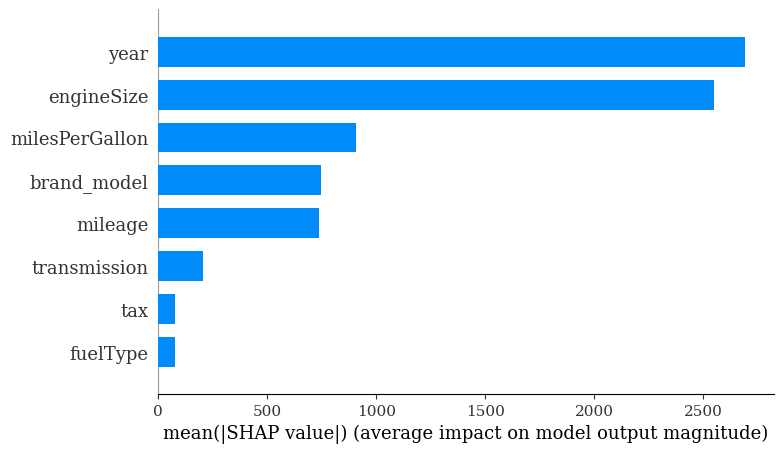

In [18]:
# Summary plot
shap.summary_plot(test_gb_shap_values, X_test, plot_type="bar", feature_names=preprocessor["cols"])

In [19]:
# Individual SHAP value plot for a specific instance (e.g., the first instance in the test set)
instance_index = 0
force_plot = shap.force_plot(gb_explainer.expected_value, test_gb_shap_values[instance_index], X_test[instance_index,:],show=False, feature_names=preprocessor["cols"])
shap.save_html("force_plot.html", force_plot)

455.35356890970553
192.4117218621614
30.44798572790202
-10.724486863092894
-383.61471547937117
-567.798567353099
-742.5126653988157
-2213.861728463209


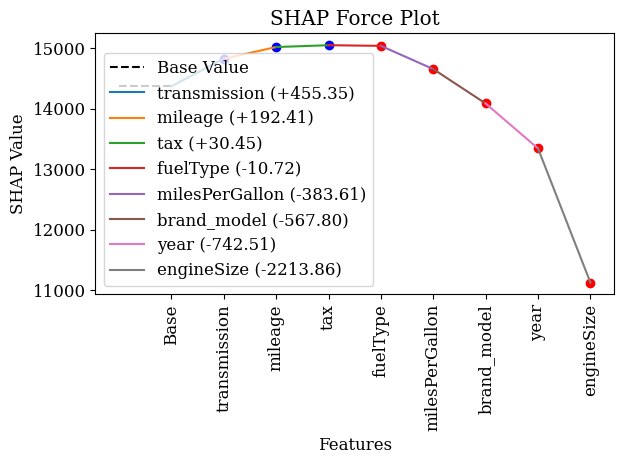

In [22]:
instance_index = 0
base_value = gb_explainer.expected_value
shap_values = test_gb_shap_values[instance_index]
feature_values = X_test[instance_index]
feature_names = preprocessor["cols"]

# Extract data for plotting
feature_contributions = sorted(zip(feature_names, shap_values), key=lambda x: x[1], reverse=True)

# Calculate the positions for each feature
positions = [base_value]
for name, value in feature_contributions:
    positions.append(positions[-1] + value)

# Plot the base value
plt.plot([0, 1], [base_value, base_value], 'k--', label='Base Value')

# Plot each feature contribution
for i, (name, value) in enumerate(feature_contributions):
    print(value)
    plt.plot([i+1, i+2], [positions[i], positions[i+1]], label=f'{name} ({value:+.2f})')
    plt.scatter([i+2], [positions[i+1]], c='b' if value > 0 else 'r')

# Add labels and legend
plt.xlabel('Features')
plt.ylabel('SHAP Value')
plt.xticks(range(1, len(feature_contributions) + 2), ['Base'] + [name for name, _ in feature_contributions], rotation=90)
plt.legend()
plt.title('SHAP Force Plot')
plt.tight_layout()
plt.show()

In [ ]:
# Plot the base value
plt.plot([0, 1], [base_value, base_value], 'k--', label='Base Value')

# Plot each feature contribution
for i, (name, value) in enumerate(feature_contributions):
    plt.plot([i+1, i+2], [positions[i], positions[i+1]], label=f'{name} ({value:+.2f})')
    plt.scatter([i+2], [positions[i+1]], c='b' if value > 0 else 'r')

# Add labels and legend
plt.xlabel('Features')
plt.ylabel('SHAP Value')
plt.xticks(range(1, len(feature_contributions) + 2), ['Base'] + [name for name, _ in feature_contributions], rotation=90)
plt.legend()
plt.title('SHAP Force Plot Recreated with Matplotlib')
plt.tight_layout()
plt.show()

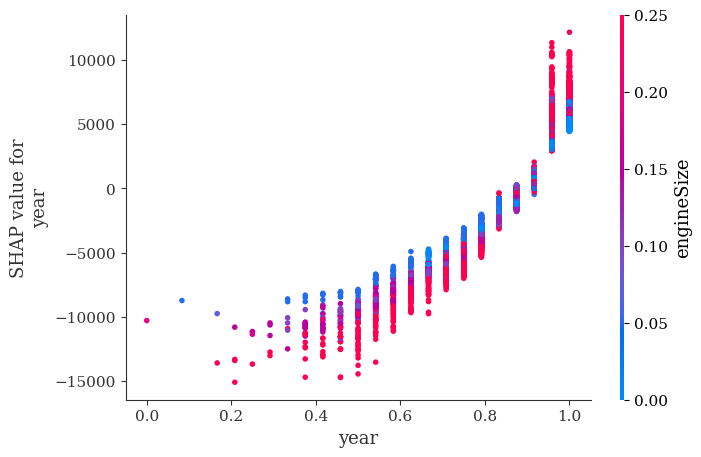

In [20]:
#Dependence plot
shap.dependence_plot(0, test_gb_shap_values, X_test, feature_names=preprocessor["cols"])

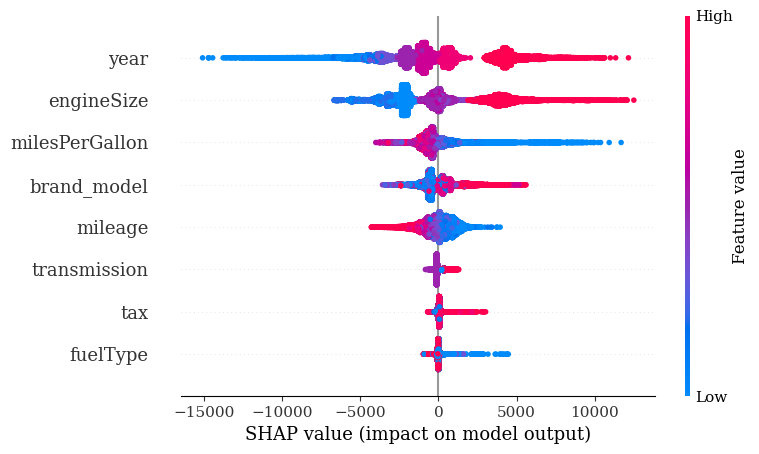

In [ ]:
#Summary plot
shap.summary_plot(test_gb_shap_values, X_test, feature_names=preprocessor["cols"])

In [ ]:
file = os.path.join(DATASET_LOC, 'model', 'shapExplainer.pkl')
joblib.dump(gb_explainer,file)

['../data/model/shapExplainer.pkl']

In [17]:
file = os.path.join(DATASET_LOC, 'model', 'shapExplainer.pkl')
explainer = joblib.load(file)

In [20]:
explainer.shap_values(X_test)

array([[-7.42512665e+02,  1.92411722e+02,  3.04479857e+01, ...,
        -5.67798567e+02,  4.55353569e+02, -1.07244869e+01],
       [ 6.73245580e+02,  7.69043046e+02, -2.05119813e+01, ...,
         2.44450564e+02, -9.54177696e+01, -3.95589110e+00],
       [-1.09537932e+03,  4.49220524e+02,  3.57696856e+01, ...,
         1.27231265e+02, -1.13037235e+02, -6.33793902e+00],
       ...,
       [-9.61345357e+03, -1.69751910e+03, -1.56406903e+01, ...,
         3.79459732e+02, -1.00294547e+02, -4.47106496e+01],
       [-8.66937169e+03, -1.62292439e+03, -1.48001874e+01, ...,
         2.82556805e+02, -9.68660403e+01, -6.04782126e+01],
       [-8.45725873e+03, -1.46236315e+03,  3.30138731e+01, ...,
         3.03361851e+02, -9.84088005e+01, -6.33756797e+01]])